In [131]:
import copy
from linearmodels.iv import IV2SLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import scipy.signal
import scipy.stats
#import sysidentpy as sipy
from scipy.fft import fft, ifft, fftshift
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mutual_info_score

from sysidentpy.metrics import mean_squared_error
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation
from IPython.display import display, HTML

plt.rc('font', size=30)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=25)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize
plt.rc('lines', linewidth=3)     # linewidth

df1 = pd.read_csv('data/U3.ASC', sep="\s+", names=['time', 'y', 'u'])
df2 = pd.read_csv('data/U1.ASC', sep="\s+", names=['time', 'y', 'u'])

# cut
df1 = df1.iloc[301:1500]
df2 = df2.iloc[301:930]

# z-normalise
joint_avg_u = np.average(df1['u'].append(df2['u']))
joint_avg_y = np.average(df1['y'].append(df2['y']))
joint_std_u = np.std(df1['u'].append(df2['u']))
joint_std_y = np.std(df1['y'].append(df2['y']))
df1['u'] = (df1['u']-joint_avg_u)/joint_std_u
df1['y'] = (df1['y']-joint_avg_y)/joint_std_y
df2['u'] = (df2['u']-joint_avg_u)/joint_std_u
df2['y'] = (df2['y']-joint_avg_y)/joint_std_y

u_train = np.asarray(df2['u']).reshape(-1, 1)
u_valid = np.asarray(df1['u']).reshape(-1, 1)
y_train = np.asarray(df2['y']).reshape(-1,1)
y_valid = np.asarray(df1['y']).reshape(-1,1)

/tmp/ipykernel_368/2279324654.py:40: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_u = np.average(df1['u'].append(df2['u']))
/tmp/ipykernel_368/2279324654.py:41: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_y = np.average(df1['y'].append(df2['y']))
/tmp/ipykernel_368/2279324654.py:42: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_u = np.std(df1['u'].append(df2['u']))
/tmp/ipykernel_368/2279324654.py:43: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_y = np.std(df1['y'].append(df2['y']))


# The four-step IV

# Step 1: estimate the regressors via LS

In [132]:
# make a copy of the training data
df_1 = copy.deepcopy(df2)

# define lags
lag = 10

# create a list of labels
lagged_u = ['u_lag'+str(i) for i in range(1, lag+1)]
lagged_y = ['y_lag'+str(i) for i in range(1, lag+1)]

# adding lags to the dataset
for i in range(1, lag+1):
    df_1['y_lag'+str(i)] = df_1['y'].shift(i)
for i in range(1, lag+1):
    df_1['u_lag'+str(i)] = df_1['u'].shift(i)

# dropping NA values (created due to shifting)
df_1 = df_1.dropna()

# using a function
# model_LS_1 = IV2SLS(dependent=df_1['y'],
#                     exog=df_1[lagged_y+lagged_u],
#                     endog=None,
#                     instruments=None) # same as sm.OLS(df_1['y'],df_1[lagged_y+lagged_u])
# results_1 = model_LS_1.fit()
# #save results
# theta_1_df = results_1.params
# theta_1 = np.asarray(theta_1_df)
# print(theta_1_df)

# solve by hand
X_1 = np.asarray(df_1[lagged_y+lagged_u])
y_1 = np.asarray(df_1['y'])
theta_1 = np.linalg.inv(X_1.T.dot(X_1)).dot(X_1.T).dot(y_1)

def simulate(theta, y0, u):
    theta = np.asarray(theta) # shape (lag+lag,)
    y0 = np.asarray(y0)       # shape (lag,)
    u = np.asarray(u)         # shape (l, lag)

    l = u.shape[0]
    y = copy.deepcopy(y0)

    for i in range(l):
        y_next = np.concatenate((y[:lag],u[i,:])) @ theta # one step ahead prediction
        y = np.concatenate(([y_next],y))

    return y[::-1][lag:]

## Step 2: Simulate the model

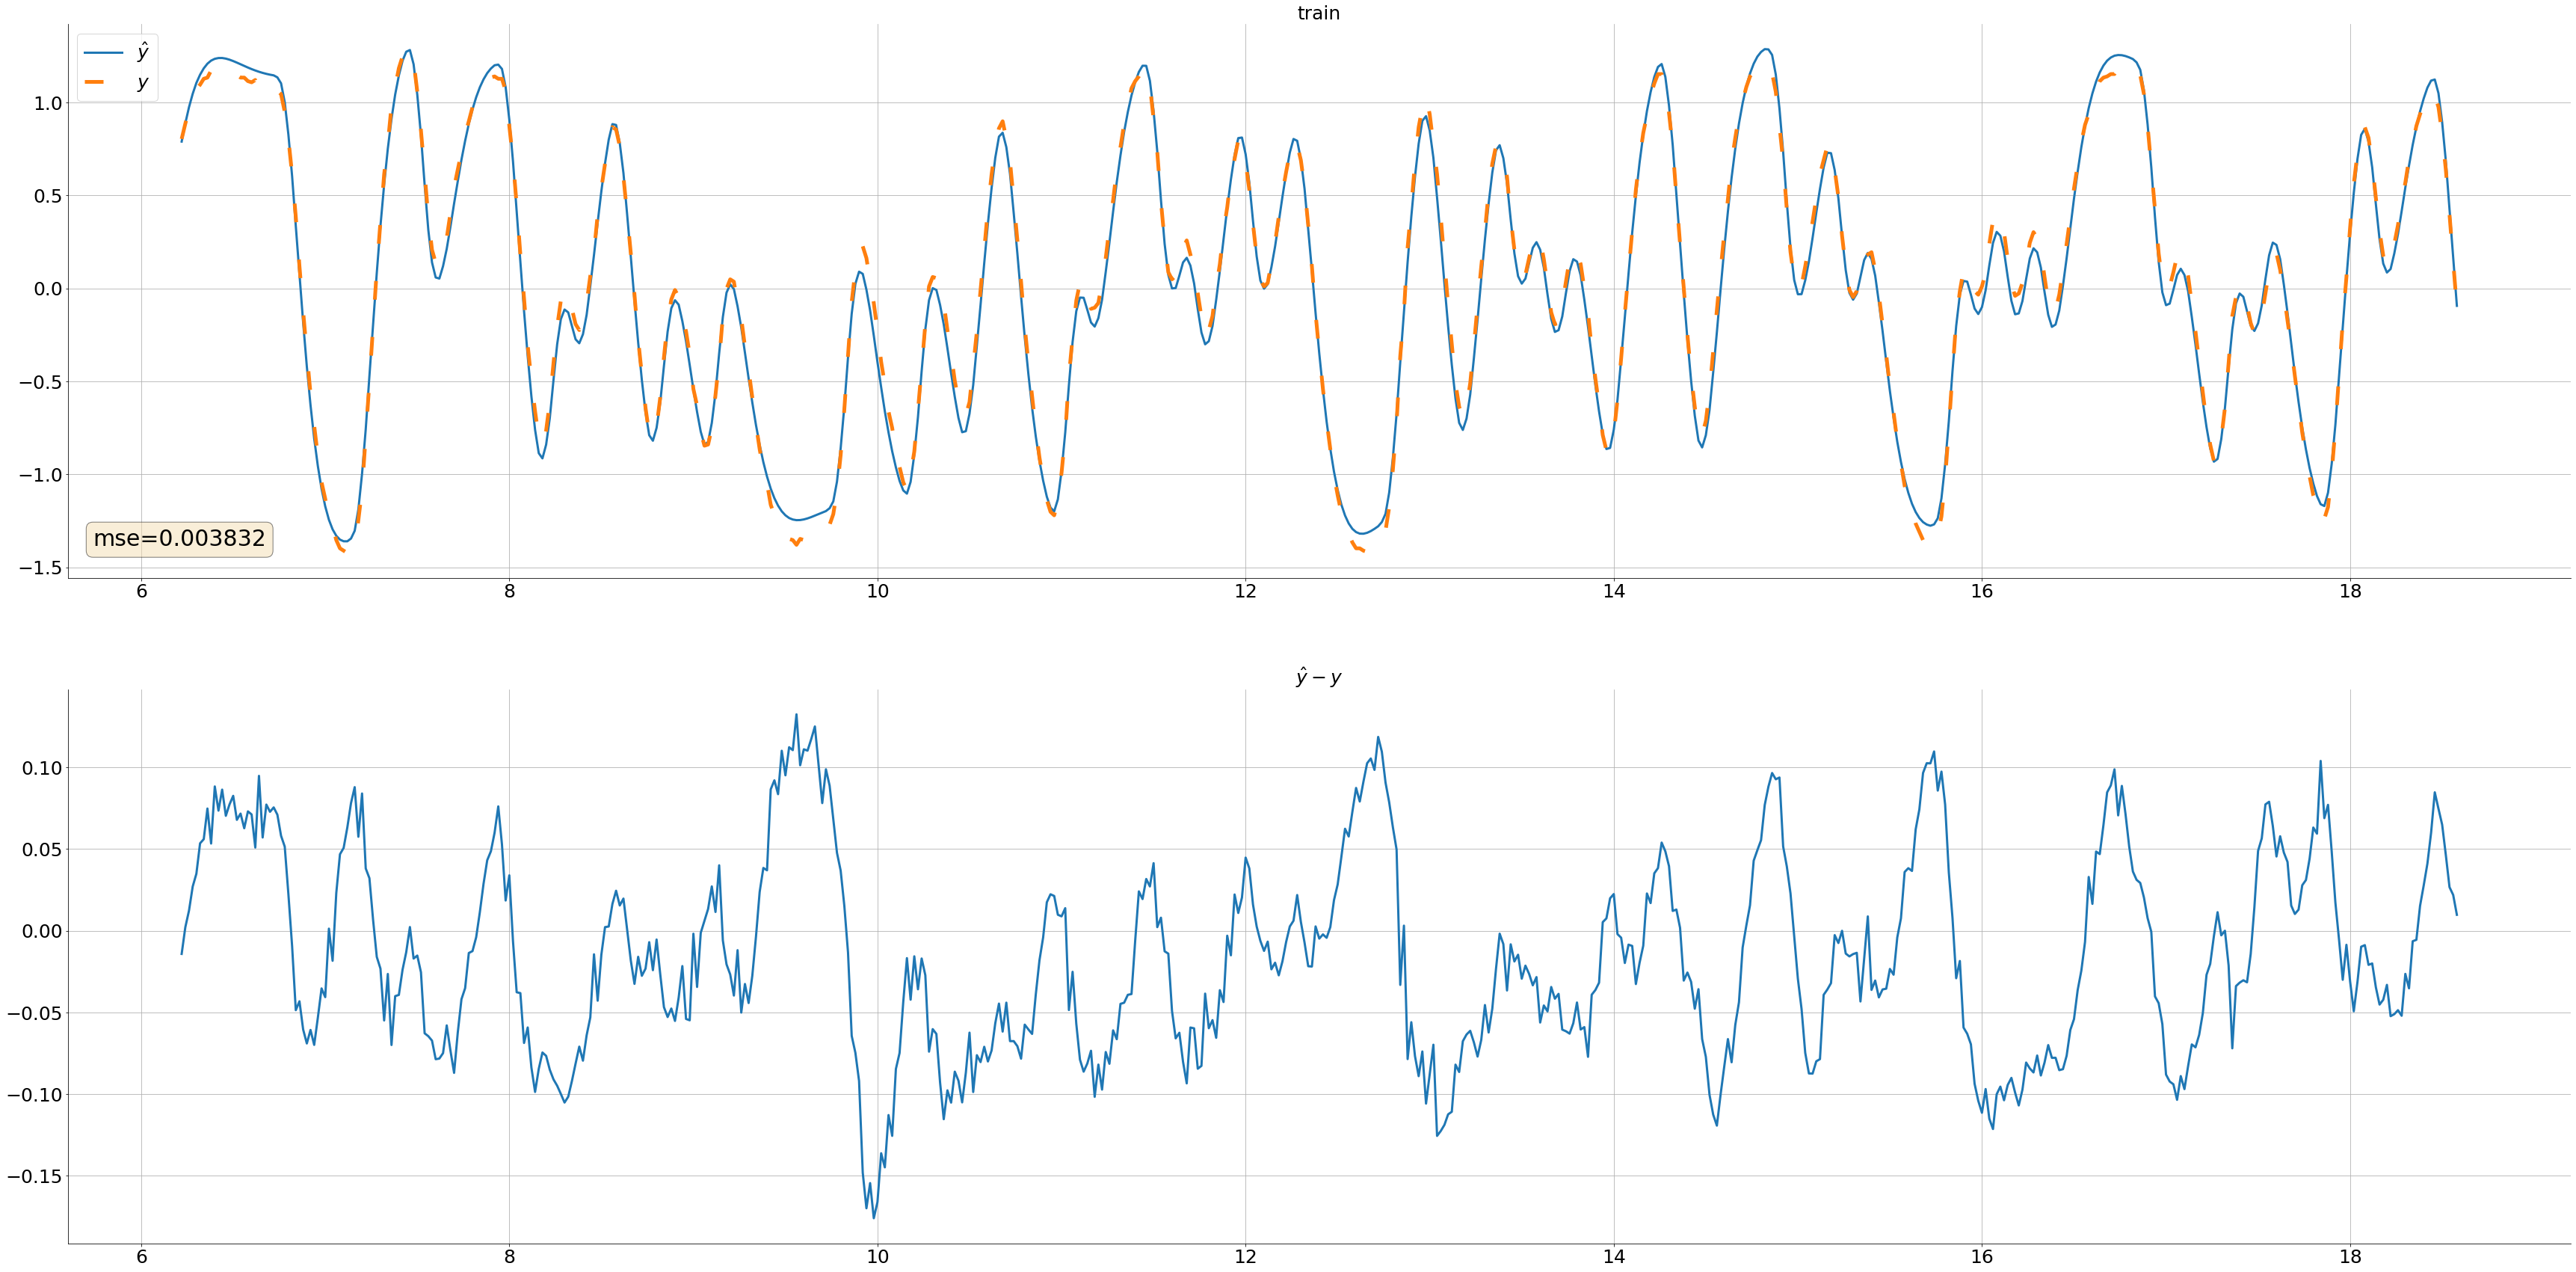

In [133]:
# simulate model
df_1['x'] = simulate(theta_1, df_1[lagged_y].iloc[0, :], df_1[lagged_u])
#df_1['x'] = np.asarray(df_1[lagged_y+lagged_u]) @ theta_1

# training error
mse_train_1 = mean_squared_error(df_1['x'], df_1['y'])

fig, axn = plt.subplots(2,1,figsize=(60,30))
axn[0].plot(np.asarray(df_1['time']), df_1['x'], label=r'$\hat{y}$')
axn[0].plot(np.asarray(df_1['time']), np.asarray(df_1['y']), label=r'$y$', linestyle=(0, (5,10)), lw=5)
axn[0].set_title('train')
axn[0].legend(loc=2)
axn[0].text(0.01, 0.05, 'mse={}'.format(round(mse_train_1,6)), transform=axn[0].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axn[0].grid(True)
axn[1].plot(np.asarray(df_1['time']),df_1['x'] - np.asarray(df_1['y']))
axn[1].set_title(r'$\hat{y}-y$')
axn[1].grid(True)

## Step 3: generate instruments with the ARX model, IV estimate coefficients theta

0.7959333222364444 0.7978392171907914 -0.0019058949543470094
0.42426031220975347 0.41782860488695794 0.006431707322795521
0.03299499640733039 0.03834669346581543 -0.005351697058485039
-0.144105959517989 -0.14900343038010178 0.004897470862112785
-0.12802197878342758 -0.12716712109254802 -0.0008548576908795624
-0.18415187863987903 -0.1792695525132434 -0.004882326126635639
0.0848646944278435 0.08804263831661796 -0.0031779438887744593
0.023943739505759565 0.015278656488766806 0.008665083016992758
0.06924262757624178 0.07289120403126714 -0.003648576455025365
-0.04393749757664607 -0.04438054290462622 0.000443045327980153
0.003921347986965166 0.004037389491791339 -0.00011604150482617294
0.011699109235946727 0.011701499242688124 -2.390006741397055e-06
0.036555404253225565 0.03654037908458368 1.5025168641887021e-05
0.040736891195927 0.04072856312615804 8.328069768963331e-06
0.02014282584996281 0.020254255944481617 -0.00011143009451880515
0.00969209092111797 0.009913443999965799 -0.0002213530788

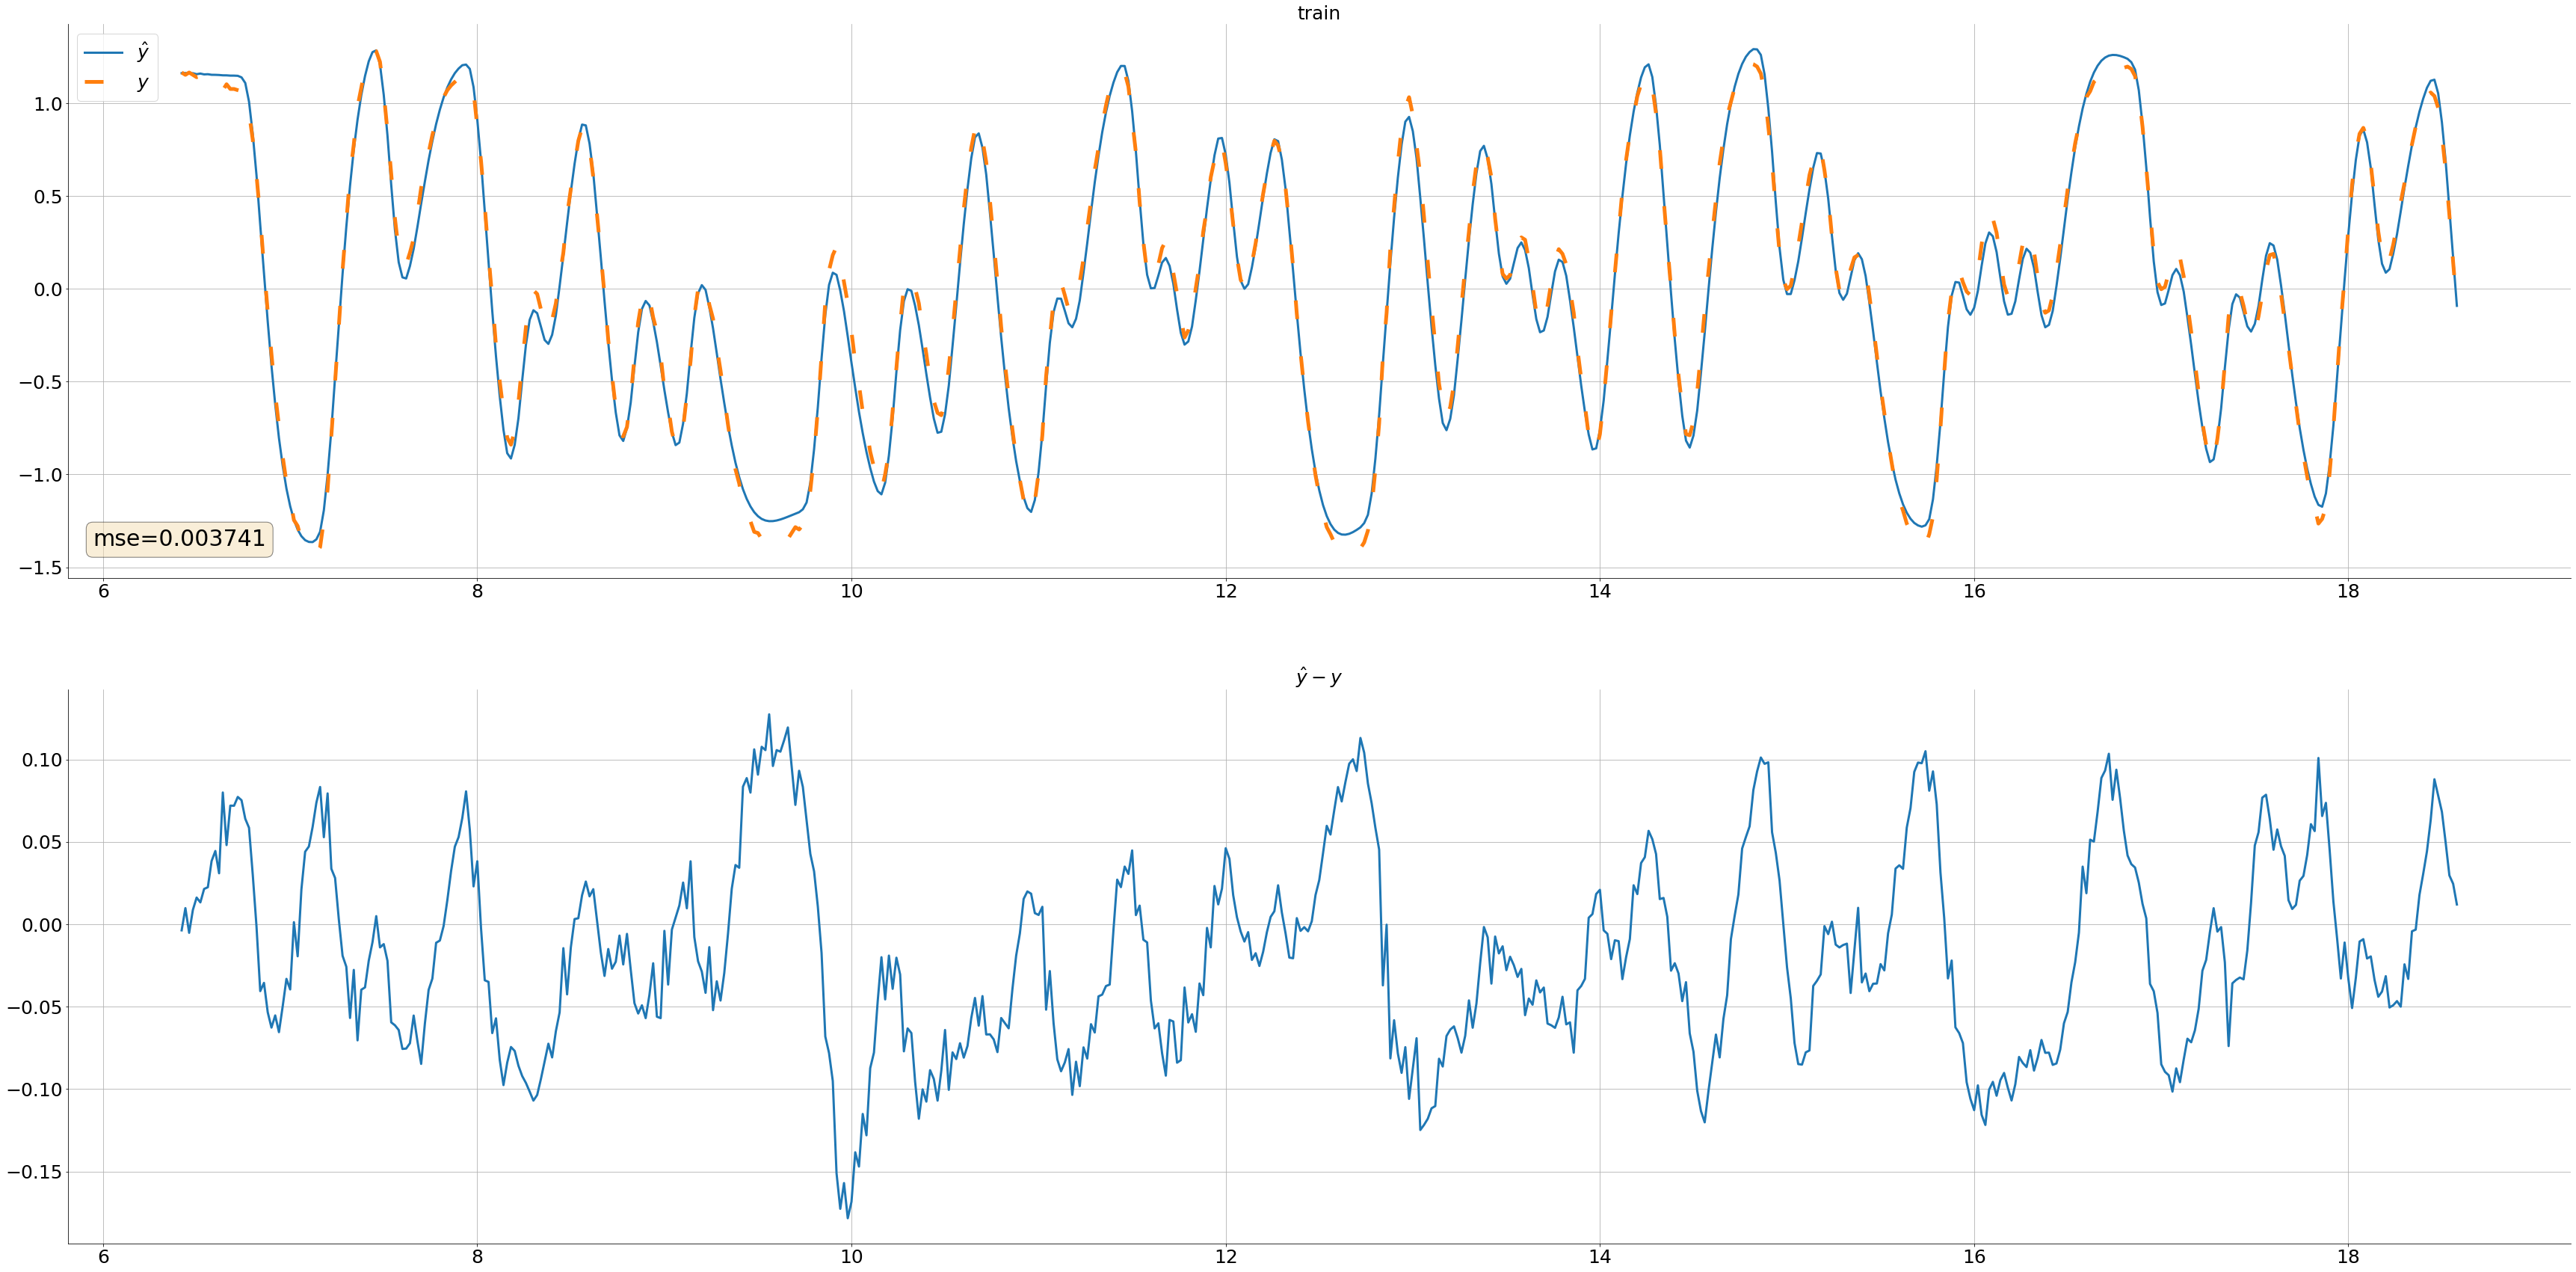

In [143]:
df_2 = copy.deepcopy(df_1)

lagged_x = ['x_lag'+str(i) for i in range(1, lag+1)]

# adding lags to the dataset
for i in range(1, lag+1):
    df_2['x_lag'+str(i)] = df_2['x'].shift(i)

df_2 = df_2.dropna()

# sovle IV by hand
Z = np.asarray(df_2[lagged_x+lagged_u])
X = np.asarray(df_2[lagged_y+lagged_u])
y = np.asarray(df_2['y'])
theta_2 = np.linalg.inv(Z.T @ X) @ Z.T @ y

for i in range(len(theta_1)):
    print(theta_1[i], theta_2[i], theta_1[i] - theta_2[i])

# # solve with IV
# model_iv_2 = IV2SLS(dependent=df_2['y'],
#                     exog=df_2[lagged_u],
#                     endog=df_2[lagged_y],
#                     instruments=-df_2[lagged_x] # notice th minus
#                     )
# results_2 = model_iv_2.fit()
#
# #save results
# theta_2_df = results_2.params
# theta_2 = np.asarray(theta_2_df)

# simulate model
df_2['x'] = simulate(theta_2, df_2[lagged_y].iloc[0, :], df_2[lagged_u])
#df_2['x'] = np.asarray(df_2[lagged_y+lagged_u]) @ theta_2

# training error
mse_train_2 = mean_squared_error(df_2['x'], df_2['y'])

fig, axn = plt.subplots(2,1,figsize=(60,30))
axn[0].plot(np.asarray(df_2['time']), df_2['x'], label=r'$\hat{y}$')
axn[0].plot(np.asarray(df_2['time']), np.asarray(df_2['y']), label=r'$y$', linestyle=(0, (5,10)), lw=5)
axn[0].set_title('train')
axn[0].legend(loc=2)
axn[0].text(0.01, 0.05, 'mse={}'.format(round(mse_train_2,6)), transform=axn[0].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axn[0].grid(True)
axn[1].plot(np.asarray(df_2['time']),df_2['x'] - df_2['y'])
axn[1].set_title(r'$\hat{y}-y$')
axn[1].grid(True)